# Importazione delle librerie e del materiale
Importo le librerie necessarie per il corretto funzionamento del notebook. Successivamente, dopo aver settato alcuni parametri, carico le immagini custom da google drive per l'assignment. Inoltre scarico la versione 3.4.2.17 di opencv in modo tale da sfruttare l'algoritmo SIFT grazie alla funzione *cv.xfeatures2d.SIFT_create()*

In [ ]:
!pip install opencv_contrib_python==3.4.2.17 --force-reinstall

  Using cached opencv_contrib_python-3.4.2.17-cp37-cp37m-manylinux1_x86_64.whl (30.6 MB)
  Using cached numpy-1.21.4-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 3.4.2.17
    Uninstalling opencv-contrib-python-3.4.2.17:
      Successfully uninstalled opencv-contrib-python-3.4.2.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5]

from google.colab.patches import cv2_imshow

# File management
from google.colab import drive
from shutil import copyfile

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
copyfile('gdrive/MyDrive/images/beach_1.jpeg','beach_1.jpeg')
copyfile('gdrive/MyDrive/images/beach_2.jpeg','beach_2.jpeg')
im1=cv.imread('beach_1.jpeg',0)
im2=cv.imread('beach_2.jpeg',0)

In [ ]:
im1.shape

(1200, 1600)

In [ ]:
im2.shape

(1200, 1600)

Entrambe le immagini sono di dimensioni 1200 (h) x 1600 (l)

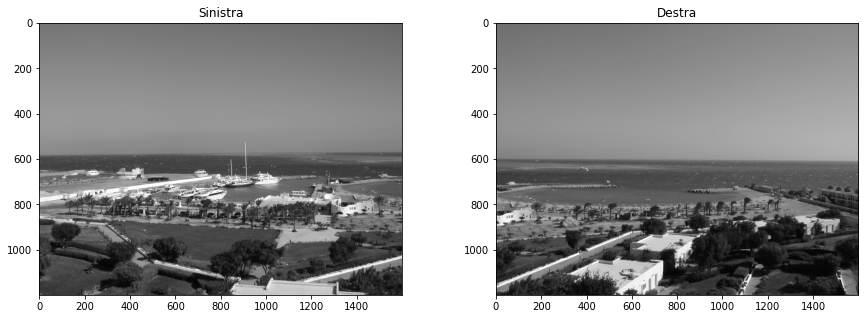

In [ ]:
plt.subplot(1,2,1); plt.imshow(im1,cmap='gray'); plt.title('Sinistra')
plt.subplot(1,2,2); plt.imshow(im2,cmap='gray'); plt.title('Destra'); plt.show();

Si inizializza l'algoritmo SIFT per l'individuazione dei keypoints all'interno delle due immagini. Una volta identificati i keypoints si effettua un matching tra i keypoints della prima immagine e quelli della seconda immagine. La procedura di matching è di tipo cross-check per ridurre al minimo il numero di falsi positivi.

In [ ]:
sift=cv.xfeatures2d.SIFT_create()
kps1,features1=sift.detectAndCompute(im1,None)
kps2,features2=sift.detectAndCompute(im2,None)
bf=cv.BFMatcher(crossCheck=True)
matches=bf.match(features1,features2)

In [ ]:
k1 = len(kps1)
k2 = len(kps2)
m = len(matches)
print(k1,k2,m)

9545 7293 4546


* Keypoints immagine 1: 9545
* Keypoints immagine 2: 7293
* Matches: 4546

Si rappresentano i 50 migliori matches, utilizzando come criterio la distanza. Le corrispondenze tra keypoints saranno contraddistinte da un segmento giallo. Si notano corrispondenze evidenti nel tratto comune alle 2 immagini.

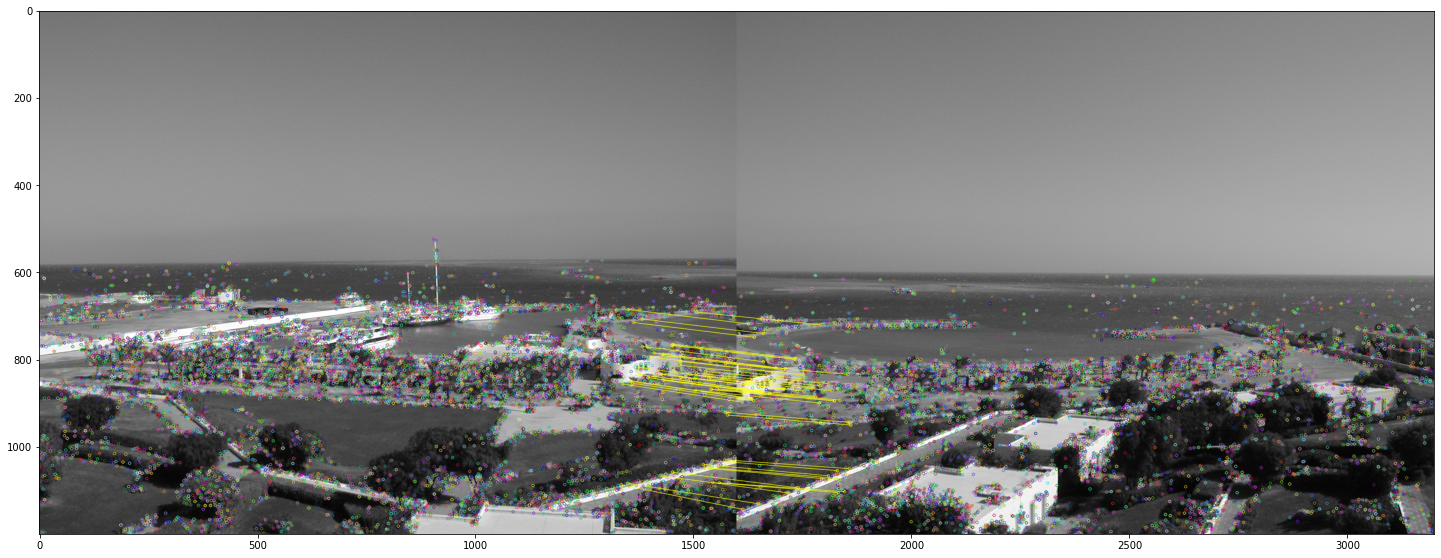

In [ ]:
matches = sorted(matches, key = lambda x:x.distance)
res = cv.drawMatches(im1, kps1, im2, kps2, matches[:50], None, matchColor = [255,255,0])
plt.figure(figsize=(25,20))
plt.imshow(res); plt.show()


Si definisce una funzione di omografia *myHomography()* in grado di restituire la matrice di trasformazione H che mappa i punti dell'immagine 2 nei punti corrispondenti presenti nell'immagine 1.



In [ ]:
def myHomography(kps1,kps2,matches):
  
  id_1 = []
  id_2 = []
  for i in range(0,len(matches)):
    pos_1 = matches[i].queryIdx #queryIdx restituisce gli indici dei keypoints 1 per ogni coppia match
    pos_2 = matches[i].trainIdx #trainIdx restituisce gli indici dei keypoints 2 per ogni coppia match

    id_1.append(kps1[pos_1].pt)
    id_2.append(kps2[pos_2].pt)
  
  id_1_array = np.asarray(id_1)
  id_2_array = np.asarray(id_2)


  H, mask = cv.findHomography(id_2_array, id_1_array, method=cv.RANSAC)
  return H

In [ ]:
H=myHomography(kps1,kps2,matches)


Una volta costruita la matrice H, attraverso una nuova funzione *myWarp()* si rimappano i punti dell'immagine 2 su un contenitore più grande in grado di contenere poi il collage delle immagini. Di default imposto la medesima altezza delle due foto e come larghezza il doppio (personalizzabile da parametro factor) sfruttando la matrice H ricavata in precedenza.

In [ ]:
def myWarp(im, H, factor=2):
  contenitore = cv.warpPerspective(im2, H, dsize=(int(im.shape[1]*factor), im.shape[0]))
  return contenitore

In [ ]:
canva=myWarp(im2,H)

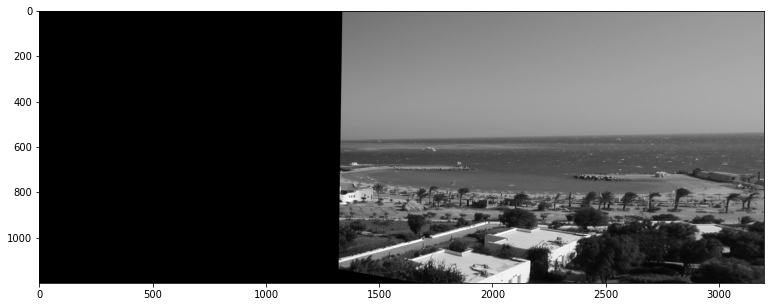

In [ ]:
plt.imshow(canva, cmap='gray'); plt.show()


Dall'immagine 2 trasformata si può vedere come effettivamente gli oggetti presenti anche nell'immagine 1 si trovino nella stessa posizione proprio dell'immagine di destinazione. Si procede a restringere la nostra immagine 2 rimappata, riducendola alla sola porzione da attaccare all'immagine 1 per prolungarla. Infine si concatenano le due immagini.

In [ ]:
def myCollage(im_base,im_new):
    porzione = im_new[0:im_base.shape[0], im_base.shape[1]+1:]
    collage = np.concatenate((im_base, porzione), axis=1)
    return collage

In [ ]:
panorama=myCollage(im1,canva)

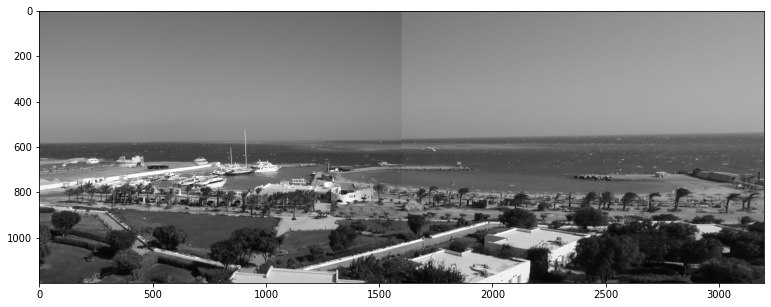

In [ ]:
plt.imshow(panorama, cmap='gray'); plt.show()


Come si può vedere il procedimento è riuscito ed il risultato è coerente con quanto ci si aspettava anche se si può ancora chiaramente distinguere il punto di attaccamento delle 2 immagini, in particolare per il cambio di esposizione delle due foto e per il cambio d'altezza del mare all'orizzonte.